## Initialize the Env

In [1]:

import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Dict
import wandb

from brax import envs
from brax.envs.base import PipelineEnv, State
from brax.training.agents.ppo import train as ppo
from brax.io import model
from brax.io import mjcf as mjcf_brax

from dm_control import mjcf as mjcf_dm

import mujoco
from mujoco import mjx
import os

import yaml
from typing import Dict, Text

from Rodent_Env_Brax import Rodent


In [2]:
!nvidia-smi

Wed Mar 27 15:53:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000000:3D:00.0 Off |                    0 |
| N/A   33C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/n/home05/charleszhang/.conda/envs/stac-mjx/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=3521315) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


## Load the Checkpoint


*Notes*: Really understand the train.ppo and the brax.acting, to see how we can manage to load the checkpoint and generate another eval from the checkpoint

In [3]:
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)
n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")

config = {
    "env_name": "rodent",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 4096*n_gpus,
    "num_timesteps": 500_000_000,
    "eval_every": 1_000_000,
    "episode_length": 1000,
    "batch_size": 4096*n_gpus,
    "learning_rate": 5e-5,
    "terminate_when_unhealthy": True,
    "run_platform": "Harvard",
    "solver": "cg",
    "iterations": 4,
    "ls_iterations": 4,
}

envs.register_environment('rodent', Rodent)

# instantiate the environment
env_name = config["env_name"]
env = envs.get_environment(env_name, 
                           terminate_when_unhealthy=config["terminate_when_unhealthy"],
                           solver=config['solver'],
                           iterations=config['iterations'],
                           ls_iterations=config['ls_iterations'])

Using 4 GPUs


In [4]:
from brax.training.agents.ppo import networks as brax_networks
from typing import Any, Dict, Sequence, Tuple, Union, Optional

# Copy and pasted from https://github.com/google/brax/discussions/403#discussioncomment-7287194
def make_inference_fn(
    observation_size: int,
    action_size: int,
    normalize_observations: bool = False,
    network_factory_kwargs: Optional[Dict[str, Any]] = None,
):
  normalize = lambda x, y: x
  ppo_network = brax_networks.make_ppo_networks(
      observation_size,
      action_size,
      preprocess_observations_fn=normalize,
      **(network_factory_kwargs or {}),
  )
  make_policy = brax_networks.make_inference_fn(ppo_network)
  return make_policy

make_policy = make_inference_fn(
    observation_size=env.observation_size,
    action_size=env.action_size,
)


In [19]:
model_path = "model_checkpoints/e6c78d3a-ca6e-488f-903a-5ec40773eecf/152043520"
params = model.load_params(model_path)
jit_inference_fn = jax.jit(make_policy(params, deterministic=False))

## Render the Clip

In [20]:
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [21]:
env.dt

Array(0.01, dtype=float32, weak_type=True)

In [22]:
# initialize the state
rng = jax.random.PRNGKey(100)
state = jit_reset(rng)
rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 1000
render_every = 1

# might becasue brax does not clip the action to the xml limit in the model
for i in tqdm(range(n_steps)):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  # print(ctrl)
  state = jit_step(state, ctrl)
  
  rollout.append(state.pipeline_state)
  states.append(state)

100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


In [23]:
os.environ["MUJOCO_GL"] = "egl"

video_path = model_path + '.mp4'
video = env.render(rollout[::render_every], camera='close_profile', height=500, width=500)
media.write_video(video_path, video, fps=1.0 / env.dt / render_every)

In [10]:
import cv2
import PIL.Image

qs = [r.q for r in rollout]
rewards = [r.reward for r in states]

In [11]:
states[-1].metrics

{'distance_from_origin': Array(0.5393484, dtype=float32),
 'forward_reward': Array(3.2325385, dtype=float32),
 'reward_alive': Array(1., dtype=float32, weak_type=True),
 'reward_linvel': Array(3.2325385, dtype=float32),
 'reward_quadctrl': Array(-0.94732046, dtype=float32),
 'x_position': Array(0.53126186, dtype=float32),
 'x_velocity': Array(0.32325384, dtype=float32),
 'y_position': Array(0.09276308, dtype=float32),
 'y_velocity': Array(-0.05945339, dtype=float32)}

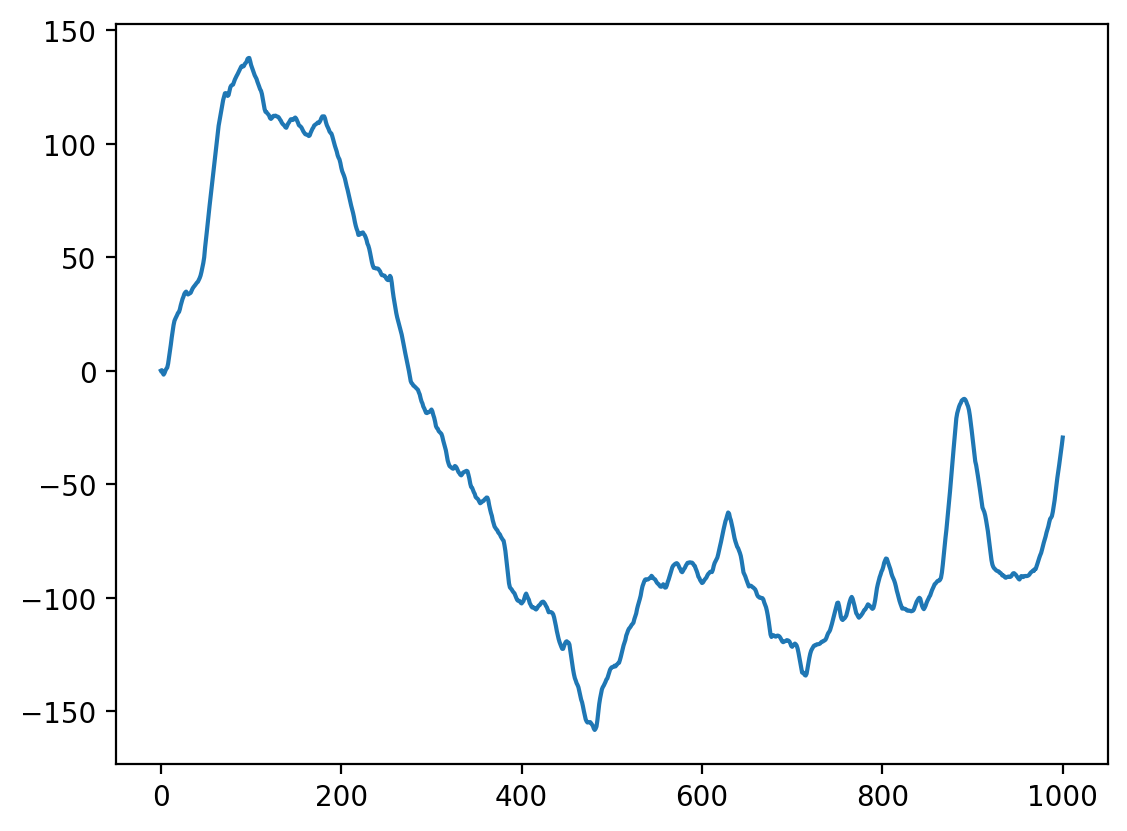

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(np.cumsum(rewards))
plt.show()


In [13]:
len(qs[0])

74

In [14]:
def plot_kinematics(qs, up_to, idx=-1, total_len=2000):
    fig = plt.figure(figsize=(5, 5))
    if idx == -1:
        qs = [r.q for r in rollout[:up_to]]
        for _idx in range(len(qs[0])):
            plt.scatter(up_to, qs[up_to-1][_idx], c="r")
    else:
        # qs = [r.subtree_com[1][idx] for r in rollout[:up_to]]
        qs = [r.q[idx] for r in rollout[:up_to]]
        plt.scatter(up_to, qs[up_to-1], c="r")
        
    _ = plt.plot(qs, alpha=0.8)
    plt.xlim(0, total_len)
    plt.ylim(-0.15, 0.15)
    plt.axvline(x=up_to, c="r")
    
    plt.title(f"r.q[{idx}] Trajectory")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    graph = cv2.resize(graph, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
    return graph


def stack_vids(vids, qs, up_to=500, target_idx=2):
    concat_vids = []
    for idx, frame in tqdm(enumerate(vids[:up_to])):
        plot = plot_kinematics(qs, idx+1, idx=target_idx, total_len=up_to)
        total = np.hstack((frame, plot))
        concat_vids.append(total)
    return concat_vids

In [15]:
import matplotlib
matplotlib.use('svg') 

In [16]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.

videos = stack_vids(video, qs, target_idx=2)

500it [01:04,  7.70it/s]


In [17]:
media.show_video(videos, fps=30)

In [18]:
graph.shape

NameError: name 'graph' is not defined

In [ ]:
which = 2
front = 200
qs = [r.q[which] for r in rollout[:front]]
_ = plt.plot(qs, alpha=0.8)
plt.xlim(0, 2000)
plt.axvline(x=front, c="r")
plt.scatter(front, qs[front-1], c="r")
plt.title(f"r.q[{which}] Trajectory")